In [4]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.stats as ss

import folium
from folium import plugins

from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [5]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# File Directories
path_crashes = '../crashes.sample2020.csv'
path_vehicles = '../vehicles.sample.csv'
path_people = '../people.sample.csv'

# Import samples
crashes = pd.read_csv(
    path_crashes,
    parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
    low_memory=False,
    dtype=object)

vehicles = pd.read_csv(path_vehicles,
                       parse_dates=["CRASH_DATE"],
                       low_memory=False,
                       dtype=object)

people = pd.read_csv(path_people,
                     parse_dates=["CRASH_DATE"],
                     low_memory=False,
                     dtype=object)

In [7]:
train_new = pd.read_csv('Preprocessed_data.csv')

In [8]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54388 entries, 0 to 54387
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CRASH_DATE               54388 non-null  object 
 1   POSTED_SPEED_LIMIT       54388 non-null  int64  
 2   TRAFFIC_CONTROL_DEVICE   54388 non-null  object 
 3   DEVICE_CONDITION         54388 non-null  object 
 4   WEATHER_CONDITION        54388 non-null  object 
 5   LIGHTING_CONDITION       54388 non-null  object 
 6   FIRST_CRASH_TYPE         54388 non-null  object 
 7   TRAFFICWAY_TYPE          54388 non-null  object 
 8   LANE_CNT                 54388 non-null  int64  
 9   ALIGNMENT                54388 non-null  object 
 10  ROADWAY_SURFACE_COND     54388 non-null  object 
 11  ROAD_DEFECT              54388 non-null  object 
 12  INTERSECTION_RELATED_I   54388 non-null  object 
 13  NOT_RIGHT_OF_WAY_I       54388 non-null  object 
 14  HIT_AND_RUN_I         

In [42]:
train_new.groupby(['PERSON_TYPE']).size()

PERSON_TYPE
BICYCLE                  249
DRIVER                 28571
NON-CONTACT VEHICLE        9
NON-MOTOR VEHICLE         30
PEDESTRIAN               526
UNABLE TO DETERMINE     3127
dtype: int64

In [44]:
df=train_new
df.groupby(['CRASH_HOUR', 'INJURY']).size()


CRASH_HOUR     INJURY     
Afternoon      INJURED         1500
               NOT INJURED    12048
Early_morning  INJURED          552
               NOT INJURED     3341
Morning        INJURED          728
               NOT INJURED     5679
Night          INJURED         1421
               NOT INJURED     7243
dtype: int64

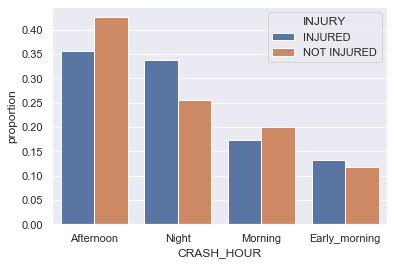

In [45]:
df=train_new
x, y, hue = "CRASH_HOUR", "proportion", "INJURY"
hue_order = ["Not Injured", "Injured"]
x_order = ['Night','Afternoon','Morning','Early_morning']

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

- Night : No right of the way, Fail to reduce speed, improper driving behavior
- Morning : No right of the way, Follow too closely, improper driving behavior
- Early morning : No right of the way, Follow too closely, Fail to reduce speed, improper driving behavior
- Afternoon : No right of the way, Follow too closely, improper driving behavior, fail to reduce the speed

In [81]:
pd.set_option('display.max_rows', 200)
df=train_new
df.groupby(['CRASH_HOUR', 'PRIM_CONTRIBUTORY_CAUSE']).size().reset_index(name='count').sort_values(['CRASH_HOUR','count','PRIM_CONTRIBUTORY_CAUSE'], ascending=False)

CRASH_HOUR                            PRIM_CONTRIBUTORY_CAUSE  count
121          Night                      FAILING TO YIELD RIGHT-OF-WAY   1429
122          Night                              FOLLOWING TOO CLOSELY   1384
120          Night             FAILING TO REDUCE SPEED TO AVOID CRASH    838
126          Night                        IMPROPER OVERTAKING/PASSING    635
124          Night                                   IMPROPER BACKING    581
125          Night                                IMPROPER LANE USAGE    555
127          Night                         IMPROPER TURNING/NO SIGNAL    510
109          Night                       DISREGARDING TRAFFIC SIGNALS    436
115          Night                DRIVING SKILLS/KNOWLEDGE/EXPERIENCE    354
129          Night  OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...    312
139          Night                                            WEATHER    279
108          Night                             DISREGARDING STOP SIGN    225
137          Night  UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...    188
114          Night                    DRIVING ON WRONG SIDE/WRONG WAY    118
131          Night                       PHYSICAL CONDITION OF DRIVER    111
116          Night                      EQUIPMENT - VEHICLE CONDITION    102
118          Night                   EXCEEDING AUTHORIZED SPEED LIMIT     89
111          Night                  DISTRACTION - FROM INSIDE VEHICLE     88
112          Night                 DISTRACTION - FROM OUTSIDE VEHICLE     67
119          Night                EXCEEDING SAFE SPEED FOR CONDITIONS     61
138          Night  VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...     51
105          Night                  CELL PHONE USE OTHER THAN TEXTING     40
134          Night           ROAD ENGINEERING/SURFACE/MARKING DEFECTS     37
106          Night                   DISREGARDING OTHER TRAFFIC SIGNS     30
123          Night    HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)     29
117          Night  EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST     29
104          Night                                             ANIMAL     16
133          Night                      ROAD CONSTRUCTION/MAINTENANCE     14
135          Night                                            TEXTING     13
107          Night                         DISREGARDING ROAD MARKINGS     13
136          Night                               TURNING RIGHT ON RED     10
113          Night  DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGAT...      7
128          Night          MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT      6
132          Night                                RELATED TO BUS STOP      4
110          Night                            DISREGARDING YIELD SIGN      2
130          Night                         PASSING STOPPED SCHOOL BUS      1
86         Morning                      FAILING TO YIELD RIGHT-OF-WAY   1289
87         Morning                              FOLLOWING TOO CLOSELY   1110
91         Morning                        IMPROPER OVERTAKING/PASSING    583
89         Morning                                   IMPROPER BACKING    508
90         Morning                                IMPROPER LANE USAGE    437
80         Morning                DRIVING SKILLS/KNOWLEDGE/EXPERIENCE    437
85         Morning             FAILING TO REDUCE SPEED TO AVOID CRASH    430
92         Morning                         IMPROPER TURNING/NO SIGNAL    374
74         Morning                       DISREGARDING TRAFFIC SIGNALS    180
103        Morning                                            WEATHER    178
93         Morning  OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...    115
73         Morning                             DISREGARDING STOP SIGN    111
102        Morning  VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...     93
81         Morning                      EQUIPMENT - VEHICLE CONDITION     87
95         Morning                       PHYSICAL CONDITION OF DRIVER     84
76  

Insight 1 :  **Posted_speed_limit is higher in Night > Afternoon > Early_morning > Morning**

In [82]:
df=train_new
df.groupby(['CRASH_HOUR', 'POSTED_SPEED_LIMIT']).size().reset_index(name='count').sort_values(['POSTED_SPEED_LIMIT','CRASH_HOUR', 'count'], ascending=False)

CRASH_HOUR  POSTED_SPEED_LIMIT  count
57          Night                  70      1
13      Afternoon                  60      2
56          Night                  55     10
42        Morning                  55      7
26  Early_morning                  55     10
12      Afternoon                  55      5
55          Night                  50      2
41        Morning                  50      2
25  Early_morning                  50      2
54          Night                  45     64
40        Morning                  45     31
24  Early_morning                  45     26
11      Afternoon                  45     62
53          Night                  40    117
39        Morning                  40     76
23  Early_morning                  40     66
10      Afternoon                  40    115
52          Night                  35    763
38        Morning                  35    479
22  Early_morning                  35    375
9       Afternoon                  35   1015
37        Morning                  32      2
51          Night                  30   6617
36        Morning                  30   4710
21  Early_morning                  30   2871
8       Afternoon                  30  10462
50          Night                  25    479
35        Morning                  25    378
20  Early_morning                  25    226
7       Afternoon                  25    725
49          Night                  20    227
34        Morning                  20    261
19  Early_morning                  20    153
6       Afternoon                  20    380
48          Night                  15    188
33        Morning                  15    217
18  Early_morning                  15     83
5       Afternoon                  15    403
47          Night                  11      2
46          Night                  10    107
32        Morning                  10    106
17  Early_morning                  10     22
4       Afternoon                  10    186
45          Night                   9      3
44          Night                   5     36
31        Morning                   5     45
16  Early_morning                   5     24
3       Afternoon                   5     80
30        Morning                   3      1
15  Early_morning                   3      1
2       Afternoon                   3      1
29        Morning                   2      1
28        Morning                   1      2
1       Afternoon                   1      2
43          Night                   0     48
27        Morning                   0     89
14  Early_morning                   0     34
0       Afternoon                   0    110

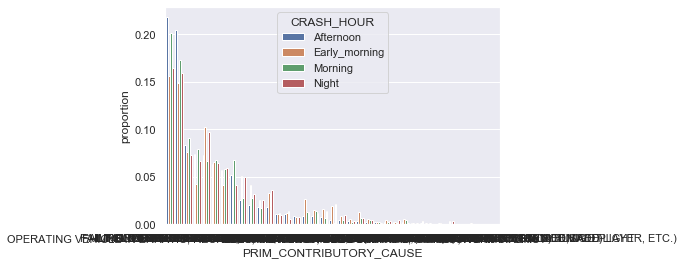

In [53]:
x, y, hue = "PRIM_CONTRIBUTORY_CAUSE", "proportion", "CRASH_HOUR"
# hue_order = ["Not Injured", "Injured"]
# x_order = ['Night','Afternoon','Morning','Early_morning']

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [46]:
df=train_new
x,y = 'CRASH_HOUR', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
df1 = df1[df1["CRASH_HOUR"]=="Early_morning"]


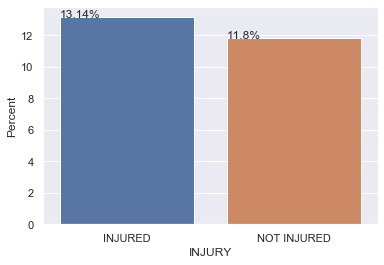

In [47]:
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

In [ ]:
df=train_new
x,y = 'CRASH_HOUR', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
df1 = df1[df1["CRASH_HOUR"]=="Night"]
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

In [ ]:
df=train_new
x,y = 'CRASH_HOUR', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
df1 = df1[df1["CRASH_HOUR"]=="Early_morning"]

In [ ]:
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

In [ ]:
ax = df.groupby(['INJURY','CRASH_HOUR'])['CRASH_HOUR'].count().unstack(0).plot.bar(title="Number of crashes for each CRASH_HOUR", 
                                                                                                  figsize=(14,8), color=['red', 'blue'])
_ = ax.set_xlabel('CRASH HOUR')
_ = ax.set_ylabel('INJURY')

# Normalize result
result_pct = result.div(result.sum(1), axis=0)

ax = result_pct.plot(kind='bar',figsize=(15,4),width = 0.8,color = colors_list,edgecolor=None)
plt.legend(labels=result.columns,fontsize= 14)
plt.title("Percentage of Respondents' Interest in Data Science Areas",fontsize= 16)

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])


# for p in ax.patches:
#     width = p.get_width()
#     height = p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center')

df=train_new
x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="DISREGARDING TRAFFIC SIGNALS"]
    
for p in ax.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
    ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center')

In [ ]:
train_new.info()

In [54]:
df=train_new
x,y = 'CRASH_HOUR', 'PRIM_CONTRIBUTORY_CAUSE'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["CRASH_HOUR"]=="Early_morning"]


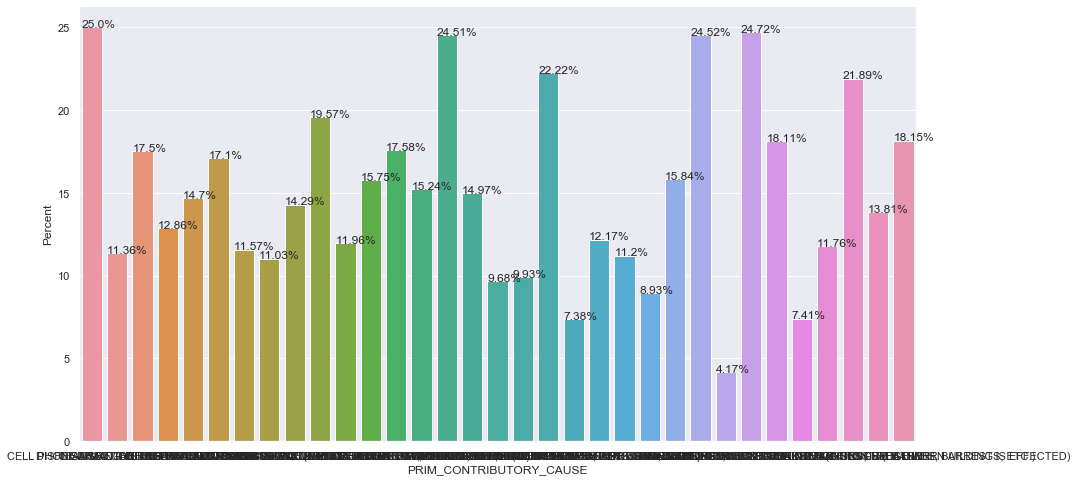

In [62]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x="PRIM_CONTRIBUTORY_CAUSE", y="Percent", data=df1)

for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

In [ ]:
# from matplotlib import pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(15,8))
# ax = sns.barplot(x="Word", y="Frequency", data=boxdata)

In [ ]:
plt.figure(figsize = (10,8))
df = df[(df.INJURY == 'NOT INJURED') & (train_new.VEHICLE_AGE < 50)]
sns.distplot(df['VEHICLE_AGE'], bins=20, kde=False, label='NOT INJURED')

df =train_new[(train_new.INJURY == 'INJURED')]
sns.distplot(df['VEHICLE_AGE'], bins=40, kde=False,label='INJURED')

# Plot formatting
plt.legend(prop={'size': 12})
plt.xlim([0, 50])
plt.title('Vehicle Age',fontsize=20)
plt.xlabel('VEHICLE_AGE')
plt.ylabel('Density')

In [ ]:
plt.figure(figsize = (10,8))
df =train_new[(train_new.INJURY == 'NOT INJURED') & (train_new.VEHICLE_AGE.isin(range(0,2)))]
sns.distplot(df['AGE'], bins=30, kde=False,label='NOT INJURED')

df =train_new[(train_new.INJURY == 'INJURED') & (train_new.VEHICLE_AGE.isin(range(0,2)))]
sns.distplot(df['AGE'], bins=30, kde=False,label='INJURED')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Age of drivers involved in crash of new cars',fontsize=20)
plt.xlim([10, 80])
plt.xlabel('AGE')
plt.ylabel('Density')

In [ ]:
df=train_new
x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="DISREGARDING TRAFFIC SIGNALS"]

In [ ]:
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

In [24]:
train_new = train_new[~train_new['PRIM_CONTRIBUTORY_CAUSE'].isin(['UNABLE TO DETERMINE', 'NOT APPLICABLE'])]
train_new[train_new["FIRST_CRASH_TYPE"] == "PEDESTRIAN"].groupby(['PRIM_CONTRIBUTORY_CAUSE'])\
                                                                    .size() \
                                                                    .reset_index(name='count') \
                                                                    .sort_values(['count'], ascending=False)


PRIM_CONTRIBUTORY_CAUSE  count
15                      FAILING TO YIELD RIGHT-OF-WAY    428
14             FAILING TO REDUCE SPEED TO AVOID CRASH     59
5                        DISREGARDING TRAFFIC SIGNALS     56
27  VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...     46
18                                   IMPROPER BACKING     41
22  OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...     38
23                       PHYSICAL CONDITION OF DRIVER     23
10                DRIVING SKILLS/KNOWLEDGE/EXPERIENCE     21
28                                            WEATHER     20
4                              DISREGARDING STOP SIGN     16
7                  DISTRACTION - FROM OUTSIDE VEHICLE     12
21                         IMPROPER TURNING/NO SIGNAL      9
20                        IMPROPER OVERTAKING/PASSING      7
2                    DISREGARDING OTHER TRAFFIC SIGNS      7
3                          DISREGARDING ROAD MARKINGS      6
19                                IMPROPER LANE USAGE      5
24                                RELATED TO BUS STOP      5
0                                              ANIMAL      5
17    HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)      5
16                              FOLLOWING TOO CLOSELY      5
12                   EXCEEDING AUTHORIZED SPEED LIMIT      5
11  EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST      4
9                     DRIVING ON WRONG SIDE/WRONG WAY      4
25                               TURNING RIGHT ON RED      3
26  UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...      3
6                   DISTRACTION - FROM INSIDE VEHICLE      2
1                   CELL PHONE USE OTHER THAN TEXTING      2
13                EXCEEDING SAFE SPEED FOR CONDITIONS      2
8   DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGAT...      1

In [23]:
train_new = train_new[~train_new['PRIM_CONTRIBUTORY_CAUSE'].isin(['UNABLE TO DETERMINE', 'NOT APPLICABLE'])]
train_new[train_new["FIRST_CRASH_TYPE"] == "PEDALCYCLIST"].groupby(['PRIM_CONTRIBUTORY_CAUSE'])\
                                                                    .size() \
                                                                    .reset_index(name='count') \
                                                                    .sort_values(['count'], ascending=False)



PRIM_CONTRIBUTORY_CAUSE  count
11                      FAILING TO YIELD RIGHT-OF-WAY    209
15                        IMPROPER OVERTAKING/PASSING     30
4                        DISREGARDING TRAFFIC SIGNALS     28
8                 DRIVING SKILLS/KNOWLEDGE/EXPERIENCE     27
19  VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...     26
16                         IMPROPER TURNING/NO SIGNAL     26
14                                IMPROPER LANE USAGE     26
3                              DISREGARDING STOP SIGN     17
10             FAILING TO REDUCE SPEED TO AVOID CRASH     16
7                     DRIVING ON WRONG SIDE/WRONG WAY     16
12                              FOLLOWING TOO CLOSELY     12
20                                            WEATHER     10
17  OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...      7
13                                   IMPROPER BACKING      4
2                          DISREGARDING ROAD MARKINGS      4
0              BICYCLE ADVANCING LEGALLY ON RED LIGHT      4
1                    DISREGARDING OTHER TRAFFIC SIGNS      3
9                       EQUIPMENT - VEHICLE CONDITION      2
5                   DISTRACTION - FROM INSIDE VEHICLE      2
18                               TURNING RIGHT ON RED      2
6                  DISTRACTION - FROM OUTSIDE VEHICLE      1

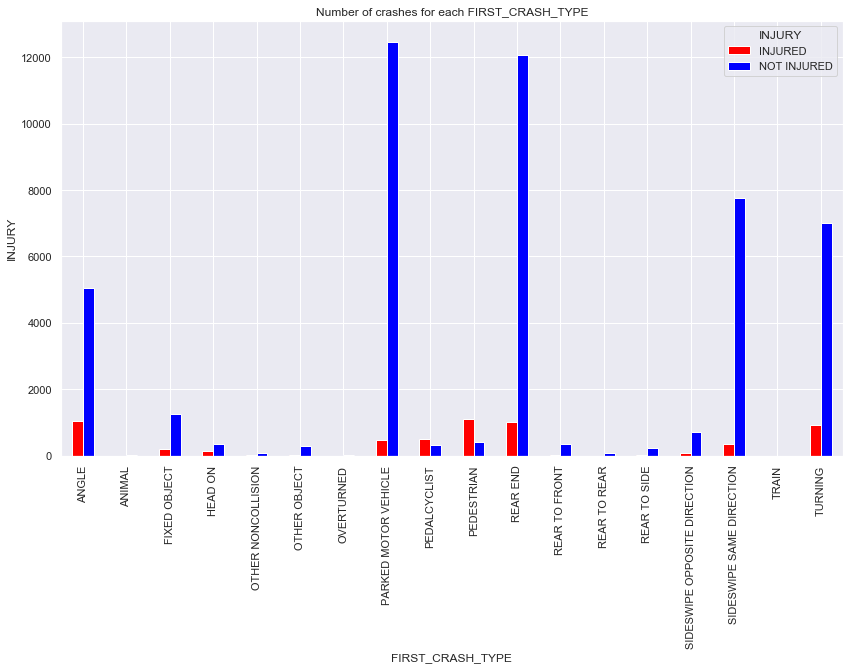

In [14]:
ax = train_new.groupby(['INJURY','FIRST_CRASH_TYPE'])['PERSON_TYPE'].count().unstack(0).plot.bar(title="Number of crashes for each FIRST_CRASH_TYPE", 
                                                                                                  figsize=(14,8), color=['red', 'blue'])
_ = ax.set_xlabel('FIRST_CRASH_TYPE')
_ = ax.set_ylabel('INJURY')

In [17]:
train_new.groupby(['PRIM_CONTRIBUTORY_CAUSE', 'INJURY']).size().reset_index()


PRIM_CONTRIBUTORY_CAUSE       INJURY    0
0                                              ANIMAL      INJURED   11
1                                              ANIMAL  NOT INJURED   37
2              BICYCLE ADVANCING LEGALLY ON RED LIGHT      INJURED    1
3              BICYCLE ADVANCING LEGALLY ON RED LIGHT  NOT INJURED    4
4                   CELL PHONE USE OTHER THAN TEXTING      INJURED   10
..                                                ...          ...  ...
70  UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...  NOT INJURED  253
71  VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...      INJURED   76
72  VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...  NOT INJURED  257
73                                            WEATHER      INJURED   87
74                                            WEATHER  NOT INJURED  800

[75 rows x 3 columns]

In [19]:
# BICYCLE & PEDESTRIAN No# INJURED > NOT INJURED
train_new.groupby(['PERSON_TYPE', 'INJURY']).size().reset_index()


PERSON_TYPE       INJURY      0
0               BICYCLE      INJURED    260
1               BICYCLE  NOT INJURED    162
2                DRIVER      INJURED   4516
3                DRIVER  NOT INJURED  41051
4   NON-CONTACT VEHICLE      INJURED      2
5   NON-CONTACT VEHICLE  NOT INJURED     11
6     NON-MOTOR VEHICLE      INJURED      5
7     NON-MOTOR VEHICLE  NOT INJURED     49
8            PEDESTRIAN      INJURED    655
9            PEDESTRIAN  NOT INJURED    223
10  UNABLE TO DETERMINE      INJURED    454
11  UNABLE TO DETERMINE  NOT INJURED   7000